In [75]:
from img_classify.dataset import *
from img_classify.downloader import *
from img_classify.evaluate_model import *
from img_classify.tools import *
from keras import Sequential
from keras.applications import *
from keras.callbacks import *
from keras.losses import *
from keras.optimizers import AdamW
from keras.src.utils import set_random_seed
from keras.layers import *
from datetime import datetime

In [76]:
# Tải dữ liệu từ thư viện Kaggle
if not os.path.exists('datasets/covid_19'):
	kaggle_downloader(
		'covid_19',
		'plameneduardo/sarscov2-ctscan-dataset'
	)

In [77]:

# Thiết lập chung
train_path = 'datasets/covid_19/'
img_save_path = 'imgs/covid_19/'
set_random_seed(69)
IMG_SIZE = (192, 192, 3)


In [78]:
# Tạo nhãn cho tập dữ liệu
class_names = create_label_from_dir(train_path)

In [79]:
# Kiểm tra ảnh trong thư mục
check_dir(train_path)

=> Have 2 subdirectories & 0 files in datasets/covid_19/
=> Have 0 subdirectories & 1252 files in datasets/covid_19/COVID
=> Have 0 subdirectories & 1229 files in datasets/covid_19/non-COVID


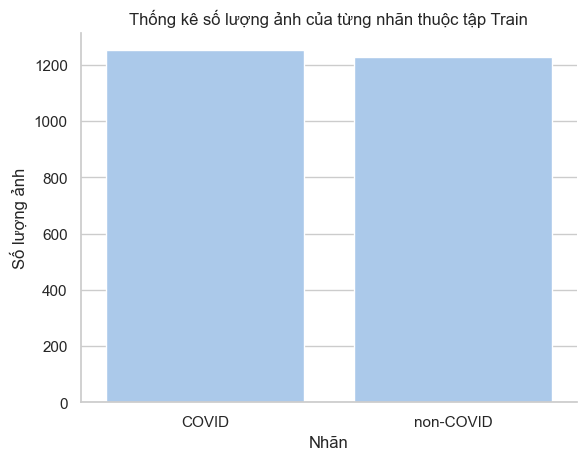

== MỨC CHÊNH LỆCH GIỮA CÁC NHÃN TẬP TRAIN SO VỚI NHÃN CAO NHẤT ==
Nhãn COVID: 100.0
Nhãn non-COVID: 98.163


In [80]:
# Kiểm tra độ cân bằng dữ liệu
check_balance(
	train_path,
	class_names,
	img_save_path=os.path.join(img_save_path, 'check_balance.jpg')
)

Loại trừ nhãn COVID do đã cân bằng !
Loại trừ nhãn non-COVID do đã cân bằng !


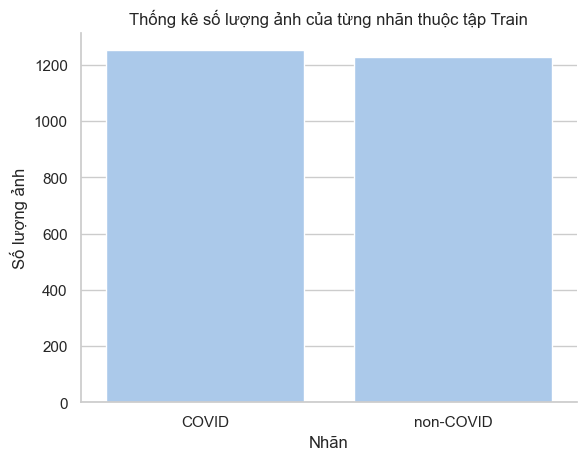

== MỨC CHÊNH LỆCH GIỮA CÁC NHÃN TẬP TRAIN SO VỚI NHÃN CAO NHẤT ==
Nhãn COVID: 100.0
Nhãn non-COVID: 98.163


In [81]:
# Tái cân bằng nhãn tập dữ liệu
img_model = ImageDataGenerator(
	horizontal_flip=True,
	zoom_range=.02
)

fix_imbalance_with_image_augmentation(
	train_path,
	img_size=(IMG_SIZE[0], IMG_SIZE[1]),
	img_model=img_model,
	class_names=class_names
)

In [82]:
## Nạp ảnh
images, labels = images_to_array(train_path, class_names, (IMG_SIZE[0], IMG_SIZE[1]))

## Tách mảng để Train/Test/Val (70/25/5)
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = train_test_val_split(
	images,
	labels,
	train_size=.70,
	test_size=.25,
	val_size=.05
)

## Tăng cường ảnh tập Train
# train_img_model = ImageDataGenerator(
# 	horizontal_flip=True,
# 	brightness_range=(.3, .7),
# 	zoom_range=.2,
# 	shear_range=.2,
# 	height_shift_range=.1
# )
# train_img_model.flow(
# 	train_images,
# 	train_labels,
# 	seed=69
# )

## Rescale ảnh
train_images = train_images / 255.
test_images = test_images / 255.
val_images = val_images / 255.

== Thống kê số lượng ảnh sau khi tách ==
Train: 1649 ảnh
Test: 621 ảnh
Val: 87 ảnh


In [83]:
# Xây dựng mô hình
def my_model():
	#  Thiết lập mô hình
	base_model = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
	base_model.trainable = False

	model = Sequential(
		[
			base_model,

			GlobalAveragePooling2D(),
			Flatten(),
			Dense(
				16, activation=LeakyReLU(alpha=.04), kernel_regularizer='l2'
			),
			Dropout(.2),
			Dense(32, activation=LeakyReLU(alpha=.04)),
			Dropout(.2),
			Dense(len(class_names), activation='sigmoid')
		]
	)

	# Biên dịch mô hình
	model.compile(
		AdamW(),
		BinaryCrossentropy(),
		['accuracy']
	)
	return model

# Chọn mô hình
model = my_model()
# Khái quát mô hình
model.summary()
# Đào tạo mô hình
history = model.fit(
	train_images,
	train_labels,
	epochs=10,
	validation_data=(test_images, test_labels),
	callbacks=[
		EarlyStopping(
			monitor='val_accuracy',
			patience=3,
			restore_best_weights=True
		),
		ReduceLROnPlateau(
			monitor='val_accuracy',
			factor=.1,
			patience=1,
			min_lr=.0001
		),
		ModelCheckpoint(
			f'models/checkpoints/covid_19/{datetime.now().strftime("%m%d%Y%H%M%S")}/',
			monitor='val_loss',
			save_best_only=True
		)
	]
)
# Lưu mô hình
model.save('models/covid_19_model.keras')
## Best result: 94%

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_8  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_8 (Flatten)         (None, 1280)              0         
                                                                 
 dense_24 (Dense)            (None, 16)                20496     
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 32)               

INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 75s 1s/step - loss: 0.8341 - accuracy: 0.6367 - val_loss: 0.5668 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.8132INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 67s 1s/step - loss: 0.5506 - accuracy: 0.8132 - val_loss: 0.4522 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8429INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 68s 1s/step - loss: 0.4708 - accuracy: 0.8429 - val_loss: 0.3793 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.3881 - accuracy: 0.8817INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 70s 1s/step - loss: 0.3881 - accuracy: 0.8817 - val_loss: 0.3421 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 5/10
52/52 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.9012INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 71s 1s/step - loss: 0.3419 - accuracy: 0.9012 - val_loss: 0.3039 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 6/10
52/52 [==============================] - 48s 933ms/step - loss: 0.3147 - accuracy: 0.9072 - val_loss: 0.3114 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 7/10
52/52 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.9187INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 61s 1s/step - loss: 0.2900 - accuracy: 0.9187 - val_loss: 0.2828 - val_accuracy: 0.9195 - lr: 1.0000e-04
Epoch 8/10
52/52 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.9284INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 60s 1s/step - loss: 0.2699 - accuracy: 0.9284 - val_loss: 0.2722 - val_accuracy: 0.9308 - lr: 1.0000e-04
Epoch 9/10
52/52 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.9381INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 59s 1s/step - loss: 0.2606 - accuracy: 0.9381 - val_loss: 0.2720 - val_accuracy: 0.9356 - lr: 1.0000e-04
Epoch 10/10
52/52 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9400INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


INFO:tensorflow:Assets written to: models/checkpoints/covid_19/03072024181236\assets


52/52 [==============================] - 58s 1s/step - loss: 0.2597 - accuracy: 0.9400 - val_loss: 0.2688 - val_accuracy: 0.9243 - lr: 1.0000e-04


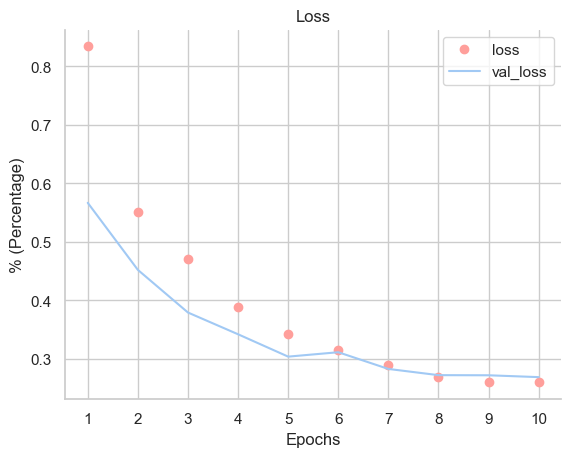

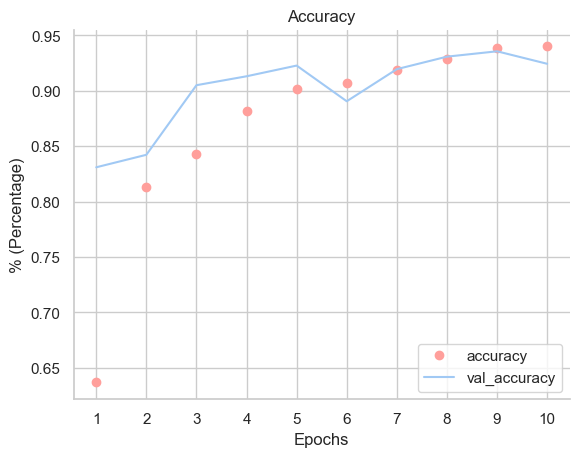

20/20 [==============================] - 11s 577ms/step - loss: 0.2688 - accuracy: 0.9243
Sai số: 0.2688390016555786
Độ chính xác: 0.9243156313896179
3/3 [==============================] - 2s 473ms/step


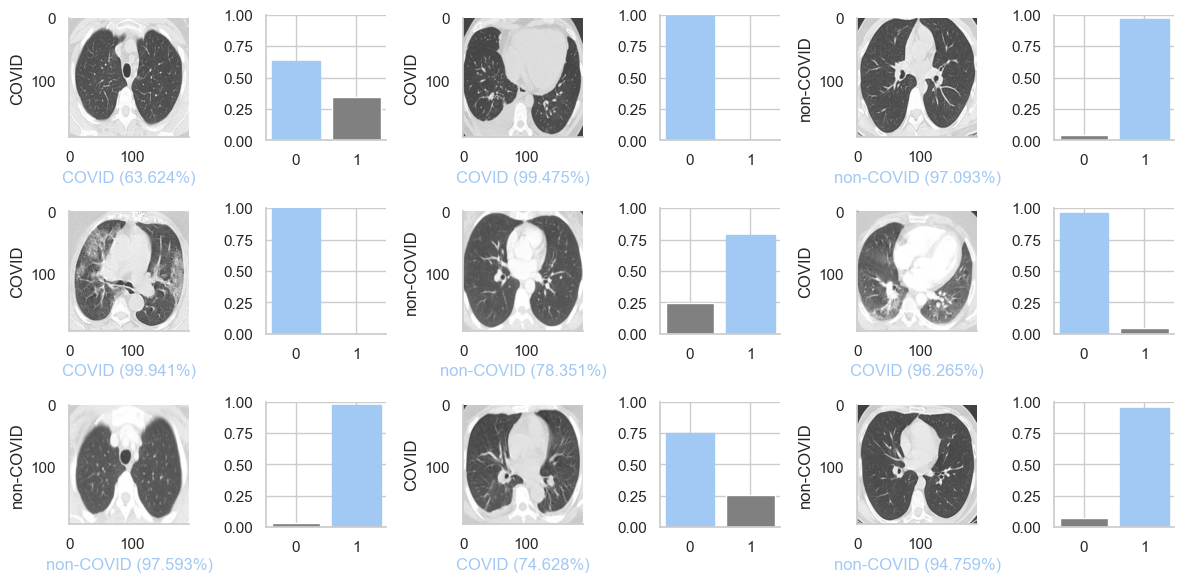

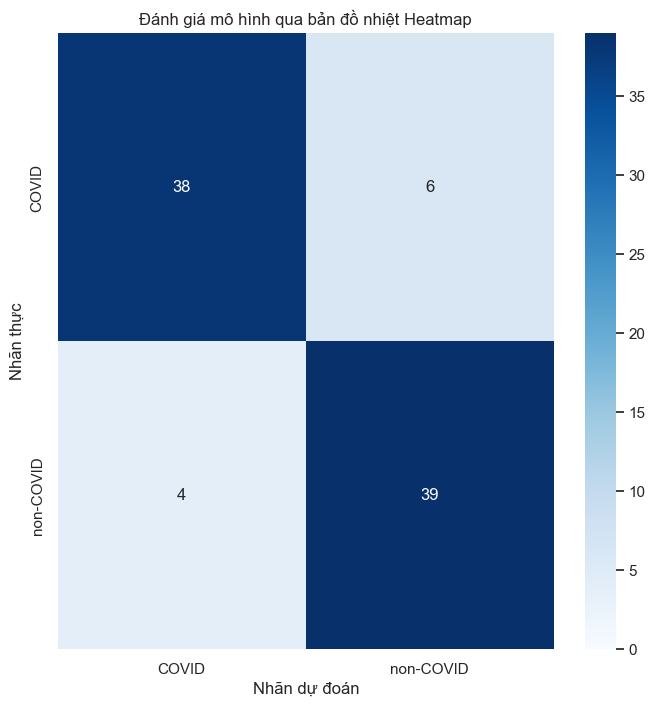

In [84]:
# Đánh giá quá trình đào tạo
EvalofTraining(history, img_save_path)
# Đánh giá mô hình qua tập Test
sai_so, do_chinh_xac = model.evaluate(test_images, test_labels)
print(f'Sai số: {sai_so}')
print(f'Độ chính xác: {do_chinh_xac}')
# Dự đoán để đánh giá mô hình
pred_labels = model.predict(val_images)
eval_of_model_with_images(
	3, 3, val_images, pred_labels, val_labels, class_names,
	img_save_path=os.path.join(img_save_path, 'eval_of_model_with_images.jpg')
)
heatmap_plot(
	val_labels, pred_labels, class_names,
	img_save_path=os.path.join(img_save_path, 'eval_of_model_with_heatmap.jpg')
)